In [1]:
print("Hey, I'm just testing here!")

Hey, I'm just testing here!


In [16]:
IMAGE_SIZE = 128
BATCH_SIZE = 32 # make it 18 or 36 for perfect fitting
CHANNELS = 3
EPOCHS = 45

In [17]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [18]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "appData",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5000 files belonging to 5 classes.


In [19]:
classNames = dataset.class_names
classNames, len(dataset)

(['Tomato_Bacterial_spot',
  'Tomato_Late_blight',
  'Tomato_Spider_mite',
  'Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato_healthy'],
 157)

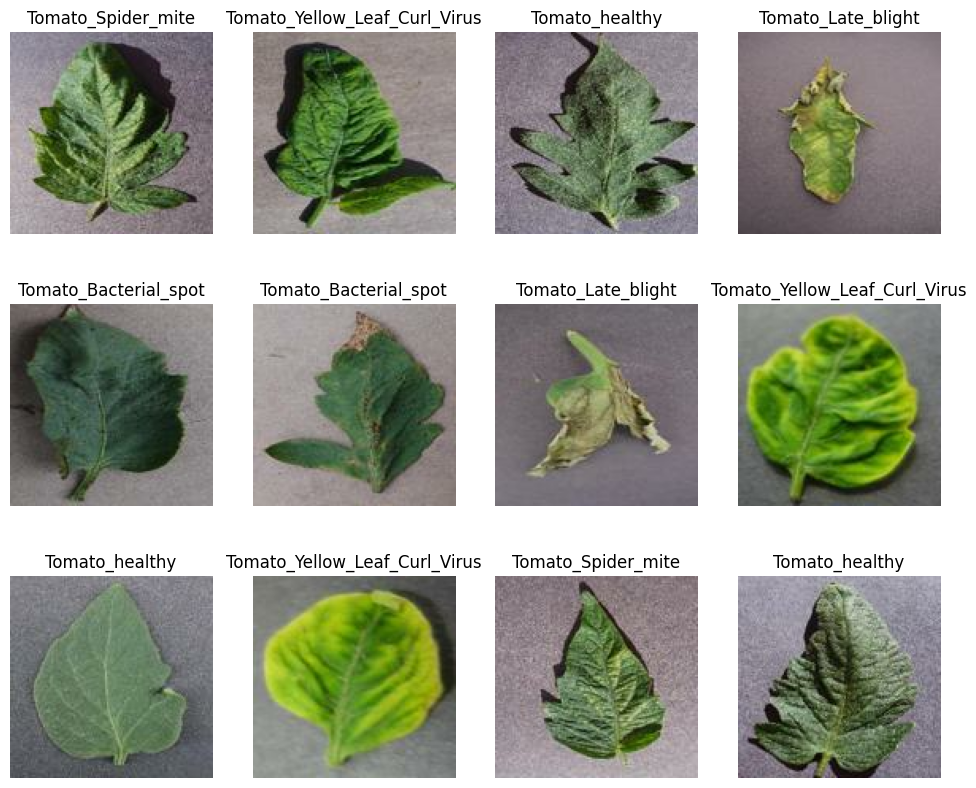

In [21]:
plt.figure(figsize=(12, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    # print(image_batch[0].numpy)
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classNames[label_batch[i]])
    plt.axis("off")

In [22]:
def getDatasetPartition(ds, trainSplit=0.8, valSplit=0.1, testSplit=0.1, shuffle=True, shuffleSize=10000):
  dsSize = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffleSize, seed=26)

  train_size = int(dsSize * trainSplit)
  val_size = int(dsSize * valSplit)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = getDatasetPartition(dataset)

In [24]:
len(train_ds), len(val_ds), len(test_ds)

(125, 15, 17)

In [25]:
train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                  

In [14]:
print(len(model.layers))

17


In [15]:
# tf_callback =  tf.keras.callbacks.TensorBoard(log_dir="../logs/", histogram_freq=1)

In [16]:
from tensorflow.python import metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    shuffle=False,
    # callbacks = [tf_callback]
)

Epoch 1/45


2023-02-27 09:15:28.081289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-02-27 09:15:30.919988: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x562a2b38aa60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-27 09:15:30.920227: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-02-27 09:15:30.995957: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-27 09:15:31.279321: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-02-27 09:15:32.830327: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The

146/146 [==============================] - 38s 181ms/step - loss: 1.3220 - accuracy: 0.4501 - val_loss: 0.9774 - val_accuracy: 0.6389
Epoch 2/45
146/146 [==============================] - 30s 203ms/step - loss: 0.7283 - accuracy: 0.7207 - val_loss: 1.5848 - val_accuracy: 0.5608
Epoch 3/45
146/146 [==============================] - 17s 117ms/step - loss: 0.5983 - accuracy: 0.7662 - val_loss: 0.9454 - val_accuracy: 0.6927
Epoch 4/45
146/146 [==============================] - 17s 116ms/step - loss: 0.5248 - accuracy: 0.8005 - val_loss: 0.5820 - val_accuracy: 0.7743
Epoch 5/45
146/146 [==============================] - 17s 117ms/step - loss: 0.4093 - accuracy: 0.8485 - val_loss: 0.8497 - val_accuracy: 0.7292
Epoch 6/45
146/146 [==============================] - 17s 116ms/step - loss: 0.3572 - accuracy: 0.8673 - val_loss: 0.5680 - val_accuracy: 0.7899
Epoch 7/45
146/146 [==============================] - 17s 116ms/step - loss: 0.2917 - accuracy: 0.8910 - val_loss: 0.4214 - val_accuracy: 0.8

In [19]:
scores = model.evaluate(test_ds)

19/19 [==============================] - 6s 49ms/step - loss: 0.0413 - accuracy: 0.9819


In [20]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

In [21]:
history.params

{'verbose': 1, 'epochs': 45, 'steps': 146}

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

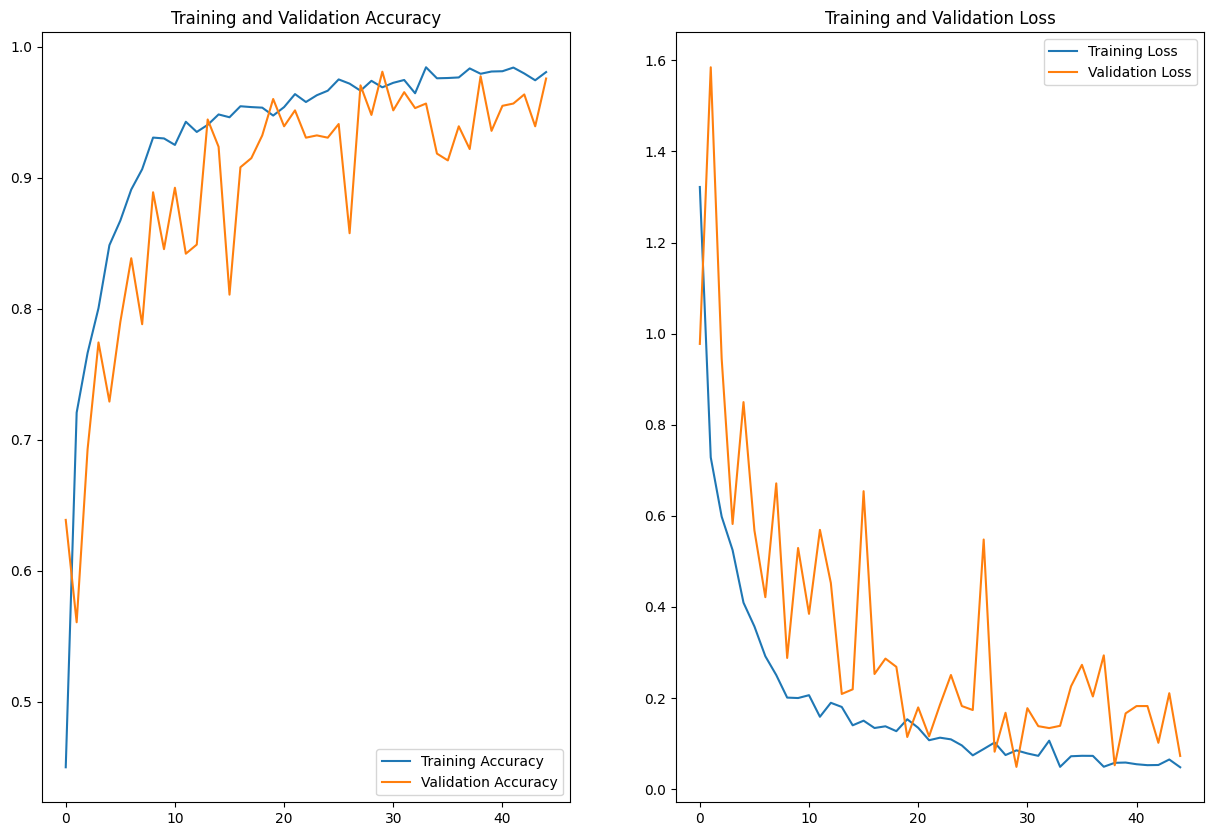

In [23]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(122)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

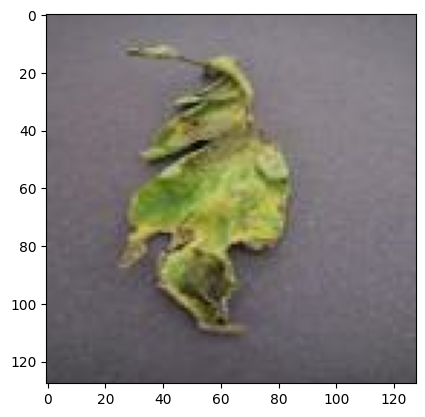

In [26]:
for images_batch, labels_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))

first image to predict
actual label:  Tomato_Yellow_Leaf_Curl_Virus


NameError: name 'model' is not defined

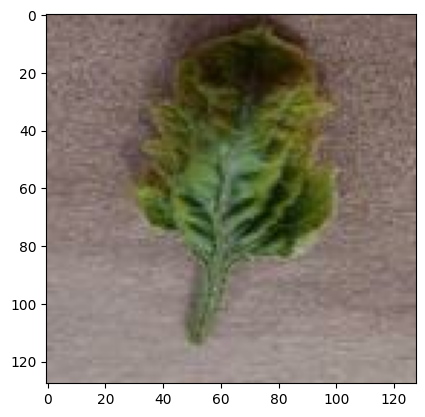

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print('first image to predict')
    plt.imshow(first_image)
    print("actual label: ", classNames[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label: ", classNames[np.argmax(batch_prediction[0])])


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
predictions = model.predict(test_data)

# Convert predictions and true labels to class names
class_names = ['Tomato Bacterial Spot', 'Tomato Late Blight', 'Tomato Spider Mite', 'Tomato Yellow Leaf Curl', 'Tomato Healthy']
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)
y_pred_names = [class_names[i] for i in y_pred]
y_true_names = [class_names[i] for i in y_true]

# Print classification report
print(classification_report(y_true_names, y_pred_names))

In [26]:
# import os
# modelVersion = max([int(i) for i in os.listdir("../../models") + [0]]) + 1
# model.save(f"../../models/{modelVersion}")

In [27]:
# model.save("../../tomatoes.h5")

In [28]:
# converter = tf.lite.TFLiteConverter.from_saved_model("../../models/2")
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()

In [29]:
# import os
# model_version = max([int(i.split(".")[0]) for i in (os.listdir("../tf-lite-models")+["0.tflite"])]) + 1

# with open(
#     f"../tf-lite-models/{model_version}.tflite",
#     'wb'
# ) as f:
#     f.write(tflite_model)

In [32]:
# def evaluate_tflite_model(dataset, interpreter):
#     input_index = interpreter.get_input_details()[0]["index"]
#     output_index = interpreter.get_output_details()[0]["index"]

#     prediction_digits = []
#     test_labels = []
#     for image, label in dataset.unbatch().take(dataset.unbatch().cardinality()):

#         test_image = np.expand_dims(image, axis=0).astype(np.float32)
#         interpreter.set_tensor(input_index, test_image)
#         interpreter.invoke()
        
#         output = interpreter.tensor(output_index)
#         digit = np.argmax(output()[0])
#         prediction_digits.append(digit)
#         test_labels.append(label)

#     prediction_digits = np.array(prediction_digits)
#     accuracy = (prediction_digits == test_labels).mean()
#     return accuracy

# interpreter = tf.lite.Interpreter(model_path="tomatoes_app.tflite")
# interpreter.allocate_tensors()

# test_accuracy = evaluate_tflite_model(dataset, interpreter)

# print('TFLite test_accuracy:', test_accuracy)

KeyboardInterrupt: 

In [31]:
# def predict(model, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
#     img_array = tf.expand_dims(img_array, 0) # Create a batch
    
#     predictions = model.predict(img_array)
    
#     predicted_class = classNames[np.argmax(predictions[0])]
#     confidence = round(100 * (np.max(predictions[0])), 2)
#     return predicted_class, confidence

In [32]:
# for images, labels in test_ds.take(1):
#     plt.figure(figsize = (16,16))
#     for i in range(9):
#         ax = plt.subplot(3, 3, i+1)
#         plt.imshow(images[i].numpy().astype('uint8'))
        
#         predicted_class, confidence = predict(model, images[i].numpy())
#         actual_class = classNames[labels[i]]
        
#         plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%" )
#         plt.axis('off')

In [33]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()